In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import xarray as xr

/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


### Temperature data 

In [3]:
temp = xr.open_dataset('/srv/scratch/z3289452/OceanDataScience/Mooring/PH100/IMOS_ANMN-NSW_TZ_20091029_PH100_FV01_TEMP-aggregated-timeseries_END-20190612_C-20190819.nc')

In [4]:
temp

<xarray.Dataset>
Dimensions:                   (INSTRUMENT: 688, OBSERVATION: 25570235)
Coordinates:
    TIME                      (OBSERVATION) datetime64[ns] ...
    LONGITUDE                 (INSTRUMENT) float32 ...
    LATITUDE                  (INSTRUMENT) float32 ...
    NOMINAL_DEPTH             (INSTRUMENT) float32 ...
Dimensions without coordinates: INSTRUMENT, OBSERVATION
Data variables:
    TEMP                      (OBSERVATION) float32 ...
    TEMP_quality_control      (OBSERVATION) float32 ...
    DEPTH                     (OBSERVATION) float32 ...
    DEPTH_quality_control     (OBSERVATION) int8 ...
    PRES                      (OBSERVATION) float32 ...
    PRES_quality_control      (OBSERVATION) float32 ...
    PRES_REL                  (OBSERVATION) float32 ...
    PRES_REL_quality_control  (OBSERVATION) float32 ...
    instrument_index          (OBSERVATION) int32 ...
    instrument_id             (INSTRUMENT) |S256 ...
    source_file               (INSTRUMENT) |S25

In [ ]:
# Nominal depth of temp instruments to compare with WQM instruments
np.unique(temp.NOMINAL_DEPTH.values)

In [ ]:
temp = temp.drop(['DEPTH','DEPTH_quality_control','PRES','PRES_quality_control','instrument_index','instrument_id','source_file'])

In [ ]:
temp = temp.where(np.logical_and(temp.TEMP_quality_control > 0, temp.TEMP_quality_control < 3), drop = True)

In [ ]:
temp = temp.where(np.logical_and(temp.PRES_REL_quality_control > 0, temp.PRES_REL_quality_control < 3), drop = True) 

In [9]:
# create pd dataframe from scratch
data  = {'TIME': temp.TIME.values,
         'TEMP': temp.TEMP.values,
         'PRES': temp.PRES_REL.values}

temp_df= pd.DataFrame(data, columns = ['TIME','TEMP','PRES'])
# set TIME as the indexing variable
temp_df = temp_df.set_index('TIME')

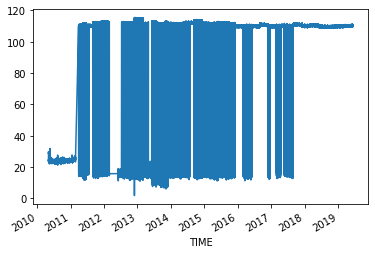

In [18]:
# Plot PRES over TIME
# Because of extra instruments (see NOMINAL_DEPTH vals), there are more pressure vals here compared to WQM
temp_df.PRES.plot()

In [39]:
# Max and min pressure values
bin_max = temp_df.PRES.max()
bin_min = temp_df.PRES.min()
bin_size = 2

In [40]:
def create_bins(bin_size, bin_max):
    """
    A function to return equal sized bins and corresponding bin labels for binning of data.
    Input:
    bin_size: size of bins
    bin_max: maximum value of the data to be binned. The minimum is assumed to be zero.
    """
    num_bins = np.ceil(bin_max/bin_size)
    lab_start = np.ceil(bin_size/2)
    bins = np.linspace(0, bin_size*num_bins, num_bins+1)
    labs = np.linspace(lab_start, bin_size*(num_bins-1)+lab_start, num_bins)
    return bins, labs

In [41]:
# Automatically calculate pressure bin parameters based on given bin_size
bins, labs = create_bins(bin_size, bin_max)

In [42]:
# create a column with pressure bin labels
temp_df['PRES_BIN'] = pd.cut(temp_df.PRES, bins = bins, labels = labs)

In [43]:
# First groupby PRES_BIN column, then resample each group on hourly intervals and mean each resulting bin
# drop unncessary columns and nan rows after
temp_df = temp_df.groupby('PRES_BIN').resample('1H').mean().drop(columns=['PRES','PRES_BIN']).dropna()

In [44]:
temp_df

TEMP
PRES_BIN TIME                          
1.0      2012-11-28 22:00:00  20.759911
3.0      2012-11-28 22:00:00  20.770100
7.0      2013-06-15 07:00:00  19.003767
         2013-06-15 08:00:00  18.982601
         2013-06-15 21:00:00  18.965900
...                                 ...
115.0    2014-11-06 22:00:00  15.896667
         2014-11-07 22:00:00  15.611667
         2014-11-07 23:00:00  15.620000
         2014-11-09 23:00:00  16.000000
         2014-11-10 00:00:00  16.036667

[149829 rows x 1 columns]

In [45]:
temp_df.groupby('PRES_BIN').count()

,TEMP
PRES_BIN,
1.0,1
3.0,1
7.0,189
9.0,3047
11.0,3400
13.0,12072
15.0,33495
17.0,10984
19.0,1395


Based on nominal depths, it looks like most readings are from the 15, 24 and 110 dbar sensors.
So we will create bins around these depths as well.

In [ ]:
bins = [0,11,19,20,28,106,114,116]
labs = [5.5,15,19.5,24,(106-28)/2,110,115]

In [ ]:
# create pd dataframe from scratch
data  = {'TIME': temp.TIME.values,
         'TEMP': temp.TEMP.values,
         'PRES': temp.PRES_REL.values}

temp_df= pd.DataFrame(data, columns = ['TIME','TEMP','PRES'])
# set TIME as the indexing variable
temp_df = temp_df.set_index('TIME')

In [14]:
# create a column with pressure bin labels
temp_df['PRES_BIN'] = pd.cut(temp_df.PRES, bins = bins, labels = labs, include_lowest=True)

In [15]:
# First groupby PRES_BIN column, then resample each group on hourly intervals and mean each resulting bin
# drop unncessary columns and nan rows after
temp_df = temp_df.groupby('PRES_BIN').resample('1H').mean().drop(columns=['PRES']).dropna()

In [16]:
temp_df.groupby('PRES_BIN').count()

,TEMP
PRES_BIN,
5.5,3919
15.0,38582
19.5,605
24.0,7391
39.0,68
110.0,65696
115.0,1891


Based on the binning above, three models will be trained: 15 dbar, 24 dbar and 110 dbar.

### 15 dbar

In [17]:
temp_df_15 = temp_df.xs(15)

In [18]:
temp_df_15

,TEMP
TIME,
2011-03-30 01:00:00,23.914965
2011-03-30 02:00:00,23.876726
2011-03-30 03:00:00,23.861305
2011-03-30 04:00:00,23.838934
2011-03-30 05:00:00,23.851543
...,...
2017-08-27 14:00:00,18.774223
2017-08-27 15:00:00,18.677221
2017-08-27 16:00:00,18.512810


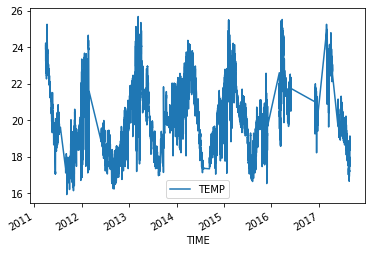

In [19]:
temp_df_15.plot()

In [21]:
Time_diff = temp_df_15.index.to_series().diff()

(array([3.8523e+04, 3.0000e+01, 6.0000e+00, 7.0000e+00, 2.0000e+00,
        4.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        7.0000e+00]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30., 185.]),
 <a list of 31 Patch objects>)

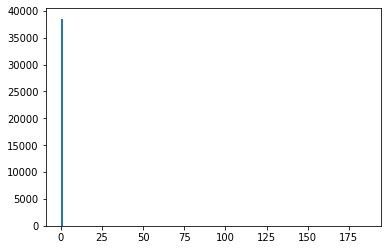

In [90]:
plt.hist((Time_diff/pd.Timedelta(days=1)), bins=np.append(np.linspace(0,30,31),185))#.where((Time_diff/pd.Timedelta(days=1)) > 1))

In [94]:
print('The longest gap in days is '+str((Time_diff/pd.Timedelta(days=1)).max())+' days (approx 6 months)')

The longest gap in days is 182.91666666666666 days (approx 6 months)


We will thus use the 6 month period before a gap and a 6 month period after a gap to predict a gap of 6 months using our RNN.

In [22]:
Time_diff.where(Time_diff > pd.Timedelta(days=7)).dropna()

TIME
2011-08-31 03:00:00    40 days 14:00:00
2012-05-31 01:00:00    92 days 00:00:00
2013-09-15 06:00:00     9 days 07:00:00
2014-09-11 01:00:00    45 days 17:00:00
2016-03-01 23:00:00    89 days 23:00:00
2016-11-30 23:00:00   182 days 22:00:00
2017-02-28 00:00:00    67 days 22:00:00
2017-05-26 01:00:00    40 days 19:00:00
Name: TIME, dtype: timedelta64[ns]

In [23]:
Time_diff.where(Time_diff > pd.Timedelta(hours=1)).min()

Timedelta('0 days 02:00:00')

If the 6 monthly model is too inaccurate, we can train a (92 day) 3 monthly model which will result in only a single gap of 182 days in the data.

#### Data generator

In [44]:
14*24

336

In [56]:
# find all locations where timeseries has gaps
temp_df_15.iloc[np.where(Time_diff > pd.Timedelta(hours=1))[0]]

,TEMP
TIME,
2011-04-08 16:00:00,24.550600
2011-04-09 15:00:00,25.100657
2011-05-21 04:00:00,20.977367
2011-05-22 04:00:00,21.429600
2011-07-04 07:00:00,20.654633
...,...
2017-04-14 18:00:00,22.955465
2017-04-14 20:00:00,22.947350
2017-04-14 22:00:00,22.880543


In [63]:
exp = 0
test = 10 if exp == 1 else 1
test

1

In [46]:
samp_seq = temp_df_15.TEMP[:1500]

In [ ]:
hist_len = 14*24
targ_len = 1

break_index = np.where(Time_diff > pd.Timedelta(hours=1))[0] - 1 
window_len = hist_len + targ_len
for w in range(len(break_index)+1):
    window_start = w
    window_end = break_index[1]
    for i in range(len(samp_seq)):
    

In [33]:
def generate_sequence(dataset, history_size, target_size):
    data = []
    labels = []

    start_index = history_size
    end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [34]:
hist_size = 182+22
targ_size = hist_size
X, y = generate_sequence(temp_df_15.TEMP, hist_size, targ_size)

KeyError: range(0, 204)

In [32]:
temp_df_15.TEMP

TIME
2011-03-30 01:00:00    23.914965
2011-03-30 02:00:00    23.876726
2011-03-30 03:00:00    23.861305
2011-03-30 04:00:00    23.838934
2011-03-30 05:00:00    23.851543
                         ...    
2017-08-27 14:00:00    18.774223
2017-08-27 15:00:00    18.677221
2017-08-27 16:00:00    18.512810
2017-08-27 17:00:00    18.349054
2017-08-27 18:00:00    18.427813
Name: TEMP, Length: 38582, dtype: float32